# Object classification using pre-trained model with classifier

 
 This model trains an object classifier. The approach is to start with a pre-trained model and to replace the last layer with a new classifier. 
 
The dataset used to develop the classifier is one of flower classification and can be found at the following address (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) . 

The notebook makes use of several other files which contain relevant classes and utility functions.  These are:

solution_manager.py: manages running the moddel for train, validate, test, and predict

composite_model.py: Manager the creation of the master model that includes a numtilayer tunable classifier with dropout and batch norm

data_manager.py: Manages the dataset and the creation of the dataloader, as well as application of the relevant transforms

utilities.py: utility functions such as saving and loading checkpoints



In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Imports here
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torchvision import models as models
import matplotlib.pyplot as plt
from PIL import Image
import os
import copy
import pickle
import sys

# Import my classes
from composite_model import Composite_Classifier
from solution_manager import Solution_Manager
from data_manager import Data_Manager
import utility

/home/tmetc/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Check for GPU and CUDA libraries
HAS_CUDA=torch.cuda.is_available()

## Load the data 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
phases = ['train', 'valid', 'test']

## Define base model and Hyper Parameters

In [5]:
# Define pre-trained model to use
pt_model = 'resnet18'
sz=224     # image size
bs=16      # Batch size
n_hid = [512, 256]
drops = [0.2, 0.2]
lr = 0.01


## Define transforms and create data manager

In [6]:
# Define transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(sz),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_mgr = Data_Manager(data_dir, phases, data_transforms, bs)


### If continuing run up to this point and then go to the Loading the checkpoint part

## Catagory to Label Mapping

Note - might have to change this depending upon the format of the datafolders and the dictionary file

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
num_cat=len(cat_to_name)
num_cat


102

## Create the composite model with new classifier

In [8]:
model_pt = models.__dict__[pt_model](pretrained=True)
num_ftrs = model_pt.fc.in_features

In [9]:
layers=list(model_pt.children())
layers


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
 ),

In [10]:
no_layers=len(list(model_pt.children()))
no_layers

10

In [11]:
# The last model of the network is the onlhy fully connected one
model_pt.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
# Instanciate the composite model
classifier = Composite_Classifier(model_pt, n_hid, drops, num_cat)

In [14]:
classifier.model_cf

Sequential(
  (0): Dropout(p=0.1)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (3): ReLU()
  (4): Dropout(p=0.1)
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=102, bias=True)
  (9): BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True)
)

## Define loss function, optimiser, scheduler and freeze layers of the pre-trained model

In [19]:
# Define losses and hyper-parameters
criterion = nn.CrossEntropyLoss()
# Optimise just the parameters of the classifier layers
optimizer_ft = optim.SGD(classifier.cf_layers.parameters(), lr=lr, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Freeze the pre-trained model layers
for param in classifier.model_pt.parameters():
    param.requires_grad = False 


In [20]:
# Instantiate the NN management class
if HAS_CUDA:
    classifier.cuda()
sol_mgr = Solution_Manager(classifier, loss_function=criterion, optimizer=optimizer_ft, 
                  scheduler=exp_lr_scheduler, data=data_mgr, phases=phases, HAS_CUDA=HAS_CUDA)

## Define number of epochs and train

In [21]:
epochs = 10

In [22]:
# Train model
sol_mgr.train(epochs=epochs)

Epoch: 1 / 10
Phase: train, loss = 2.6617, accuracy = 0.3625
Phase: valid, loss = 1.7894, accuracy = 0.5049
Epoch: 2 / 10
Phase: train, loss = 1.8649, accuracy = 0.5121
Phase: valid, loss = 1.2472, accuracy = 0.6626
Epoch: 3 / 10
Phase: train, loss = 1.4169, accuracy = 0.6195
Phase: valid, loss = 0.9873, accuracy = 0.7311
Epoch: 4 / 10
Phase: train, loss = 1.2292, accuracy = 0.6716
Phase: valid, loss = 1.0914, accuracy = 0.7152
Epoch: 5 / 10
Phase: train, loss = 0.9949, accuracy = 0.7291
Phase: valid, loss = 0.7316, accuracy = 0.7983
Epoch: 6 / 10
Phase: train, loss = 0.9428, accuracy = 0.7434
Phase: valid, loss = 0.7700, accuracy = 0.7787
Epoch: 7 / 10
Phase: train, loss = 0.8886, accuracy = 0.7618
Phase: valid, loss = 0.5847, accuracy = 0.8301
Epoch: 8 / 10
Phase: train, loss = 0.5246, accuracy = 0.8547
Phase: valid, loss = 0.3183, accuracy = 0.9071
Epoch: 9 / 10
Phase: train, loss = 0.4128, accuracy = 0.8852
Phase: valid, loss = 0.2990, accuracy = 0.9156
Epoch: 10 / 10
Phase: train,

In [24]:
# Increase LR for 2 epochs
optimizer_ft.param_groups[0]['lr'] = lr/5
sol_mgr.train(epochs=2)

Epoch: 11 / 12
Phase: train, loss = 0.3802, accuracy = 0.8916
Phase: valid, loss = 0.2975, accuracy = 0.9169
Epoch: 12 / 12
Phase: train, loss = 0.3964, accuracy = 0.8872
Phase: valid, loss = 0.2926, accuracy = 0.9132
Finished training
Best accuracy: 0.9169    Best loss: 0.2976


In [25]:
# Decrease LR again for 2 epochs
optimizer_ft.param_groups[0]['lr'] = lr/10
sol_mgr.train(epochs=2)

Epoch: 3 / 4
Phase: train, loss = 0.3914, accuracy = 0.8887
Phase: valid, loss = 0.3069, accuracy = 0.9156
Epoch: 4 / 4
Phase: train, loss = 0.3927, accuracy = 0.8863
Phase: valid, loss = 0.2899, accuracy = 0.9254
Finished training
Best accuracy: 0.9254    Best loss: 0.2899


In [26]:
# Decrease LR again for 4 epochs
optimizer_ft.param_groups[0]['lr'] = lr/20
sol_mgr.train(epochs=4)

Epoch: 3 / 6
Phase: train, loss = 0.3634, accuracy = 0.8977
Phase: valid, loss = 0.2794, accuracy = 0.9328
Epoch: 4 / 6
Phase: train, loss = 0.3489, accuracy = 0.9043
Phase: valid, loss = 0.2769, accuracy = 0.9279
Epoch: 5 / 6
Phase: train, loss = 0.3614, accuracy = 0.9003
Phase: valid, loss = 0.2728, accuracy = 0.9254
Epoch: 6 / 6
Phase: train, loss = 0.3387, accuracy = 0.9048
Phase: valid, loss = 0.2719, accuracy = 0.9267
Finished training
Best accuracy: 0.9328    Best loss: 0.2794


In [27]:
# Decrease LR again for 5 epochs
# Decrease LR again for 4 epochs
optimizer_ft.param_groups[0]['lr'] = lr/40
sol_mgr.train(epochs=4)

Epoch: 5 / 8
Phase: train, loss = 0.3473, accuracy = 0.9003
Phase: valid, loss = 0.2770, accuracy = 0.9303
Epoch: 6 / 8
Phase: train, loss = 0.3447, accuracy = 0.9009
Phase: valid, loss = 0.2729, accuracy = 0.9315
Epoch: 7 / 8
Phase: train, loss = 0.3431, accuracy = 0.9071
Phase: valid, loss = 0.2728, accuracy = 0.9315
Epoch: 8 / 8
Phase: train, loss = 0.3498, accuracy = 0.9005
Phase: valid, loss = 0.2727, accuracy = 0.9303
Finished training
Best accuracy: 0.9328    Best loss: 0.2794


In [29]:
sol_mgr.train(epochs=10)

Epoch: 5 / 14
Phase: train, loss = 0.3468, accuracy = 0.9043
Phase: valid, loss = 0.2787, accuracy = 0.9328
Epoch: 6 / 14
Phase: train, loss = 0.3480, accuracy = 0.9020
Phase: valid, loss = 0.2781, accuracy = 0.9328
Epoch: 7 / 14
Phase: train, loss = 0.3634, accuracy = 0.9000
Phase: valid, loss = 0.2780, accuracy = 0.9328
Epoch: 8 / 14
Phase: train, loss = 0.3726, accuracy = 0.8958
Phase: valid, loss = 0.2780, accuracy = 0.9328
Epoch: 9 / 14
Phase: train, loss = 0.3672, accuracy = 0.8980
Phase: valid, loss = 0.2780, accuracy = 0.9328
Epoch: 10 / 14
Phase: train, loss = 0.3474, accuracy = 0.9019
Phase: valid, loss = 0.2779, accuracy = 0.9328
Epoch: 11 / 14
Phase: train, loss = 0.3708, accuracy = 0.8990
Phase: valid, loss = 0.2778, accuracy = 0.9328
Epoch: 12 / 14
Phase: train, loss = 0.3769, accuracy = 0.8970
Phase: valid, loss = 0.2778, accuracy = 0.9328
Epoch: 13 / 14
Phase: train, loss = 0.3548, accuracy = 0.9034
Phase: valid, loss = 0.2777, accuracy = 0.9328
Epoch: 14 / 14
Phase: tr

In [30]:
sol_mgr.model.class_to_idx = data_mgr.image_datasets['train'].class_to_idx

## Run model on test set

In [31]:
sol_mgr.test_with_dl()

Phase: test, loss = 0.3436, accuracy = 0.9084


## Save the checkpoint

In [32]:
def get_checkpoint_name_and_save(model_mgr):
    """
    Save model state disctionary, optimiser state dictionary, and the solution_manager parameters necessary to
    resume at the same point
    """

    while True:
        case_name=input('Case name to use to save model :')
        directory=os.path.dirname(case_name)
        if not os.path.exists(case_name):
            os.mkdir("./"+case_name)
            break
        else:
            overwrite=input('Directory exists already, overwrite? (y or ret): ')
            if (overwrite == 'y') or (overwrite == 'Y'):
                break
                
    utility.save_checkpoint(case_name, model_mgr, pt_model, HAS_CUDA)

    return 

In [33]:
get_checkpoint_name_and_save(sol_mgr)

Case name to use to save model :test_wbn
Directory exists already, overwrite? (y or ret): y


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

### Restart procedure
To continue from the checkpoint run the top cells down to the point were it says continue to Loading the checkpoint, then contime from below

In [34]:
def get_name_load_checkpoint():
    while True:
        case_name=input('Name of checkpoint :')
        directory=os.path.dirname(case_name)
        if not os.path.exists(case_name):
            get_new_name = input(f'{case_name} does not exist.  Enter new name or q to quit: ')
            if get_new_name == 'q': 
                sys.exit('Unable to load checkpoint')
            else: case_name=get_new_name
        else:
            break
            
    # Check for cuda
    HAS_CUDA=torch.cuda.is_available()
    
    model_mgr = utility.load_checkpoint(case_name, lr, HAS_CUDA)
    return model_mgr  
    

In [36]:
sol_mgr, pt_model = get_name_load_checkpoint()

Name of checkpoint :test_wbn
Cuda device: 0
Loaded CUDA version
Checkpoint loaded


In [37]:
# Check model works by running through the test set
sol_mgr.test_with_dl()

Phase: test, loss = 0.3436, accuracy = 0.9084


In [38]:
# Train for further 4 epochs
optimizer_ft.param_groups[0]['lr'] = lr/20
sol_mgr.train(epochs=4)

Epoch: 11 / 14
Phase: train, loss = 0.7175, accuracy = 0.8088
Phase: valid, loss = 0.6112, accuracy = 0.8301
Epoch: 12 / 14
Phase: train, loss = 0.7180, accuracy = 0.8045
Phase: valid, loss = 0.5467, accuracy = 0.8557
Epoch: 13 / 14
Phase: train, loss = 0.6940, accuracy = 0.8162
Phase: valid, loss = 0.5645, accuracy = 0.8496
Epoch: 14 / 14
Phase: train, loss = 0.6388, accuracy = 0.8237
Phase: valid, loss = 0.4659, accuracy = 0.8704
Finished training
Best accuracy: 0.9328    Best loss: 0.2794


# Inference for classification

In [39]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
        
        Note - the transformations are define in the data_transforms['predict'] dictionary as defined earlier
        
    '''   
    
    image = data_transforms['test'](image).float()
    
    # Convert back to numpy array since this is what is requested
    image = image.numpy()

    return image

In [40]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.permute(1, 2, 0).numpy()
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip image between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

In [41]:
# Add utility function
def myconv(x):
    '''
    Function to convert class numbers to folder labels
    '''
    return idx_to_class[x]

def get_name(x):
    '''
    Function to convert folder lables to class names
    '''
    return cat_to_name[x]

In [47]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # TODO: Implement the code to predict the class from an image file
    # open the image
    image = Image.open(image_path)
    
    # apply transforms
    tr_image = process_image(image)
    
    # convert to tensor
    pt_image = torch.FloatTensor(tr_image)
    
    # add additional batch dimension at the start to give bn, 3, h, w
    pt_image = torch.unsqueeze(pt_image,0)
    
    # Feed image through the model using the predict method of the model manager class
    pred = sol_mgr.predict(pt_image)
    
    # obtain top 5 class IDs and probabilities
    class_probs, class_ids = pred.topk(5)
    class_probs = class_probs.numpy()
  
    class_ids = class_ids.numpy()
    class_ids = np.squeeze(class_ids)

    # Convert class numbers to folder labels
    v_myconv=np.vectorize(myconv)
    folder_labels = v_myconv(class_ids)
    
    # Convert folder labels to class names
    v_get_names=np.vectorize(get_name)
    class_names = v_get_names(folder_labels)
        
    return class_probs, class_ids, class_names, torch.squeeze(pt_image)

## Check prediction of single image



In [48]:
def get_files(path):
    '''
    Obtain name and labels of all files in sub folders of path. 
    '''
    labels = []
    filenames = []
    unique_labels = []
    for label in sorted(os.listdir(path)):
        if label not in ('.ipynb_checkpoints','.DS_Store'):
            unique_labels.append(label)
            for filename in os.listdir(os.path.join(path, label)):
                if filename not in ('.DS_Store'):
                    filenames.append(os.path.join(path, label, filename))
                    labels.append(label)
    return filenames, labels, unique_labels

Image   0 - Correct Prediction!
   filename: flowers/test/95/image_07470.jpg, Actual Class: bougainvillea
   Top 5 predicted probabilities: [[9.9862945e-01 4.4681469e-04 3.7632370e-04 1.8589947e-04 6.2256353e-05]]
   Top 5 predicted class_names: ['bougainvillea' 'pelargonium' 'lotus lotus' 'sweet pea'
 'canterbury bells']

Image   1 - Correct Prediction!
   filename: flowers/test/90/image_04468.jpg, Actual Class: canna lily
   Top 5 predicted probabilities: [[0.85529494 0.08042936 0.01289637 0.01037652 0.00567278]]
   Top 5 predicted class_names: ['canna lily' 'hibiscus' 'watercress' 'corn poppy' 'sword lily']

------------------------------------------------------------------------------------------------


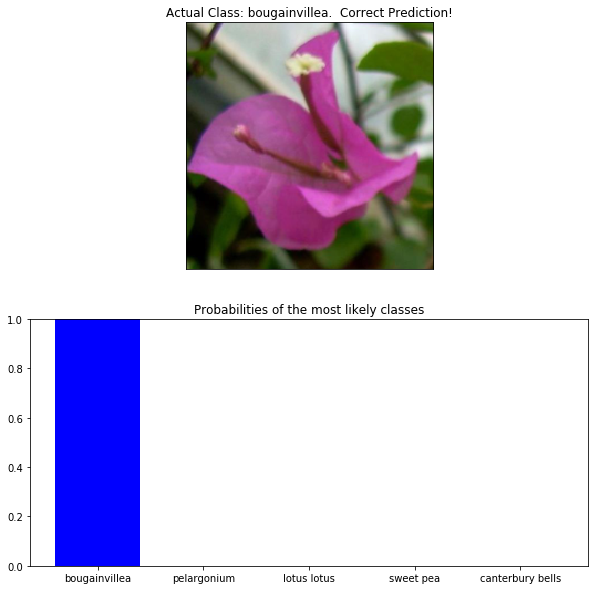

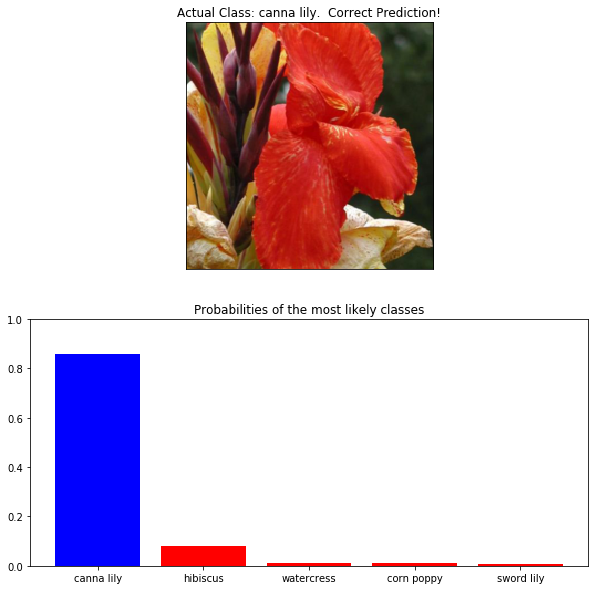

In [49]:
# create array of test set images

filenames, labels, unique_labels = get_files(test_dir)

random_idx = np.random.permutation(len(labels))

# need a path back from class number to class name and folder label

idx_to_class = [k for k,v in sol_mgr.model.class_to_idx.items()]

# Randomly select one and work out its actual class
# loop around displaying files images and classifications

ind = np.arange(5)
for img in range(2):
    fig, ax = plt.subplots(2, figsize=(10,10))
    idx = random_idx[img]
    file=filenames[idx]
    label = labels[idx]
    actual_class = cat_to_name[label]
    # generate predictions of class using model

    class_probs, class_ids, class_names, image = predict(file, sol_mgr.model, 5)
    # plot file

    correct = 'Correct Prediction!' if actual_class == class_names[0] else 'Incorrect Prediction' 
    print(f'Image {img:3d} - {correct}')
    print(f'   filename: {file}, Actual Class: {actual_class}')
    print(f'   Top 5 predicted probabilities: {class_probs}')
    print(f'   Top 5 predicted class_names: {class_names}')
    print('')
    imshow(image, ax[0])
    ax[0].set_title(f'Actual Class: {actual_class}.  {correct}')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    c0, c1, c2, c3, c4=ax[1].bar([0,1,2,3,4,], class_probs[0])
    c0.set_facecolor('b')
    c1.set_facecolor('r')
    c2.set_facecolor('r')
    c3.set_facecolor('r')
    c4.set_facecolor('r')
    ax[1].set_title('Probabilities of the most likely classes') 
    ax[1].set_ylim([0,1])
    ax[1].set_xticks(np.arange(len(ind)))
    ax[1].set_xticklabels(class_names)
    
print('------------------------------------------------------------------------------------------------')

